# Imports and Description

This notebook takes the .hdf5 file containing a Pandas dataframe that was produced from comverting the simulator cache to that dataframe.  This notebook will convert that dataframe into the needed numpy array format for training the LSTM network.

In [1]:
# Data Processing Libraries
import numpy as np
import pandas as pd
# Libraries for file reading
import h5py
# Memory management libraries for Python
import gc
# Progress Bar Libraries
from tqdm import tqdm

# Important Links

* Main link on machinelearningmastery for LSTM networks from Gary: https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/ 
* Kanna LSTM search link: https://machinelearningmastery.com/?s=LSTM&post_type=post&submit=Search
* sdlkfjsld


# Open and Read in the Pandas Dataframe

In [2]:
data_directory = 'input_data/'
data_file = 'sim_data_df-body-ts.hdf5'
raw_df = pd.read_hdf(data_directory + data_file)
raw_df

mass     acc_x     acc_y         vel_x         vel_y  \
body time_step                                                           
0.0  1.0        1390.0  2.594044  2.233110  -9031.438477  14691.001953   
     2.0        1390.0 -0.009251  2.241132  -9038.838867  16483.906250   
     3.0        1390.0 -0.409034  0.906853  -9366.065430  17209.388672   
     4.0        1390.0 -0.298435  0.421017  -9604.813477  17546.203125   
     5.0        1390.0 -0.204014  0.233022  -9768.024414  17732.621094   
...                ...       ...       ...           ...           ...   
9.0  197216.0   2689.0  0.002917  0.004731 -19296.751953  11917.413086   
     197217.0   2689.0  0.002918  0.004731 -19294.417969  11921.197266   
     197218.0   2689.0  0.002918  0.004730 -19292.083984  11924.981445   
     197219.0   2689.0  0.002919  0.004730 -19289.748047  11928.765625   
     197220.0   2689.0  0.002920  0.004730 -19287.412109  11932.549805   

                   dis_x_1     dis_y_1       vel_x_1       vel_y_1  \
body time_step                                                       
0.0  1.0        -7231071.0  13187125.0  -9038.838867  16483.906250   
     2.0        -7492852.5  13767511.0  -9366.065430  17209.388672   
     3.0        -7683851.0  14036962.0  -9604.813477  17546.203125   
     4.0        -7814419.5  14186097.0  -9768.024414  17732.621094   
     5.0        -7906783.5  14279605.0  -9883.479492  17849.505859   
...                    ...         ...           ...           ...   
9.0  197216.0  -15435534.0   9536958.0 -19294.417969  11921.197266   
     197217.0  -15433667.0   9539985.0 -19292.083984  11924.981445   
     197218.0  -15431798.0   9543012.0 -19289.748047  11928.765625   
     197219.0  -15429930.0   9546040.0 -19287.412109  11932.549805   
     197220.0  -15428061.0   9549066.0 -19285.076172  11936.333008   

                   dis_x_2  ...       vel_x_8       vel_y_8     dis_x_9  \
body time_step              ...                                           
0.0  1.0        -7492852.5  ... -10083.470703  18032.125000  -8099020.5   
     2.0        -7683851.0  ... -10123.775391  18067.373047  -8125220.5   
     3.0        -7814419.5  ... -10156.525391  18096.152344  -8146808.5   
     4.0        -7906783.5  ... -10183.510742  18120.220703  -8164801.5   
     5.0        -7974726.0  ... -10206.001953  18140.755859  -8179942.0   
...                    ...  ...           ...           ...         ...   
9.0  197216.0  -15433667.0  ... -19278.064453  11947.682617 -15420581.0   
     197217.0  -15431798.0  ... -19275.726562  11951.464844 -15418711.0   
     197218.0  -15429930.0  ... -19273.388672  11955.247070 -15416841.0   
     197219.0  -15428061.0  ... -19271.050781  11959.029297 -15414969.0   
     197220.0  -15426192.0  ... -19268.710938  11962.810547 -15413097.0   

                   dis_y_9       vel_x_9       vel_y_9    dis_x_10  \
body time_step                                                       
0.0  1.0        14453898.0 -10123.775391  18067.373047  -8125220.5   
     2.0        14476922.0 -10156.525391  18096.152344  -8146808.5   
     3.0        14496177.0 -10183.510742  18120.220703  -8164801.5   
     4.0        14512605.0 -10206.001953  18140.755859  -8179942.0   
     5.0        14526864.0 -10224.927734  18158.580078  -8192775.0   
...                    ...           ...           ...         ...   
9.0  197216.0    9561172.0 -19275.726562  11951.464844 -15418711.0   
     197217.0    9564198.0 -19273.388672  11955.247070 -15416841.0   
     197218.0    9567223.0 -19271.050781  11959.029297 -15414969.0   
     197219.0    9570248.0 -19268.710938  11962.810547 -15413097.0   
     197220.0    9573273.0 -19266.371094  11966.591797 -15411225.0   

                  dis_y_10      vel_x_10      vel_y_10  
body time_step                                          
0.0  1.0        14476922.0 -10156.525391  18096.152344  
     2.0        14496177.0 -10183.510742  18120.220703  
     3.0        14512605.0 -1

# Convert Pandas Dataframe to LSTM Numpy Arrays

We will neeed to split the data into groups of time_steps.  The time_steps value is the number of time steps in the sequence we are feeding the LSTM network. 

Training input will be the sequence group of time_steps of the mass, acc_x, acc_y, vel_x, vel_y columns.  This will result in an input numpy array with a shape of (time_steps, 5).  This numpy array is then added to a 3D input array of shape (num_samples, time_steps, 5). 

Target values are the dis_x, dis_y, vel_x, vel_y for an arbitrary number of time steps in the future.  For the initial example, we are looking to predict 10 time steps into the future for every inference.  Since we have 4 target attributes, that will give us a target numpy array of (10, 4) or (num_pred_ts, 4).  We can then take each sample and construct a 3D numpy array of (num_samples, nump_pred_ts, 4).

Overall approach will be to slice out a body, then grab the data from the time step data for that body.

## Grab the Input Vector Data

In [3]:
# Get some values from the dataframe to help calculate shapes of numpy arrays.
# Need to be careful of modified dataframe index from previous processing.
# https://stackoverflow.com/questions/28772494/how-do-you-update-the-levels-of-a-pandas-multiindex-after-slicing-its-dataframe
min_body_index = int(min(raw_df.index.get_level_values(0)))
max_body_index = int(max(raw_df.index.get_level_values(0)))
min_ts_index = int(min(raw_df.index.get_level_values(1)))
max_ts_index = int(max(raw_df.index.get_level_values(1)))
num_bodies = len(raw_df.index.get_level_values(0).unique())
num_ts = len(raw_df.index.get_level_values(1).unique())
print(min_body_index)
print(max_body_index)
print(min_ts_index)
print(max_ts_index)
print(num_bodies)
print(num_ts)

0
9
1
197220
10
197220


For example, if I have 1000 time steps per body in the raw dataset, and I want a sequence of 4 input time steps for training the LSTM network, and I assume I'm only advancing 1 time step per sequence (overlapping samples), then that would mean I am creating samples until I reach an index that is 4 time steps short of the max time step.  In this case, I would be grabbing 996 samples from the original set of 100 time steps.

The total amout of samples from all bodies and time steps would then be num_bodies * 996.

In [4]:
# Set the number of time steps to include for the input sequence to the LSTM.
num_input_ts = 4
# Set the number of features in the input sequence.
num_input_features = 5

In [5]:
# Calculate the number of samples per body.
num_samples_per_body = int(max_ts_index - num_input_ts)
# Calculate the resulting number of samples from the entire dataset.
num_samples = int(num_samples_per_body * num_bodies)
# Create an empty numpy array of the sample dimensions to store all samples.
# Fill with nan then overwrite.  Preallocating memory then writing is muuuuccchhh faster.
input_samples_np = np.full(
    (num_samples, num_input_ts, num_input_features),
    np.nan,
    dtype=np.float32
)
input_samples_np.shape

(1972160, 4, 5)

In [6]:
# JUST TESTING CODE BLOCK
# Try slicing out the beginning 5 columns.
idx = pd.IndexSlice
test_df = raw_df.loc[idx[0, :], :].iloc[:, 0:5]
curr_ts = 5
test_df.loc[idx[0, curr_ts:curr_ts+num_input_ts-1], :]#.to_numpy().shape

mass     acc_x     acc_y         vel_x         vel_y
body time_step                                                        
0.0  5.0        1390.0 -0.204014  0.233022  -9768.024414  17732.621094
     6.0        1390.0 -0.144319  0.146106  -9883.479492  17849.505859
     7.0        1390.0 -0.106160  0.099909  -9968.407227  17929.433594
     8.0        1390.0 -0.080736  0.072773 -10032.996094  17987.652344

In [7]:
# Pandas index slicer to help with slicing.
idx = pd.IndexSlice
# Keep track of the sample index
curr_sample_index = 0
# Loop over each body and extract the data for that body.
for body_index in range(min_body_index, max_body_index+1):
    # Extract the current body's data.  Assume columns to left are input data.
    # Use iloc to only extract the first 5 columns of data.
    current_body_np = raw_df.loc[idx[body_index, :], :].iloc[:, 0:num_input_features].to_numpy()
    # Loop over time steps for the num_samples_per_body to extract input sequences.
    # Store the extracted sequence as a sample in the input_samples_np numpy array.
    for curr_ts in tqdm(range(min_ts_index, max_ts_index - num_input_ts + 1)):
        # Be careful accessing time step indexes in numpy version of time series.
        # In Pandas dataframe, indexes start at 1 while indexes start at 0 in numpy.
        input_samples_np[curr_sample_index, :, :] = \
            current_body_np[(curr_ts-1):(curr_ts+num_input_ts-1), :]
        # Advance the counter that keeps track of the sample we are on.
        curr_sample_index += 1    
# Swapped to using numpy arrays on the inner loop since Pandas dataframes take
# so long to index and slice.

100%|██████████| 197216/197216 [00:00<00:00, 779325.48it/s]


In [8]:
input_samples_np.shape

(1972160, 4, 5)

In [9]:
input_samples_np[1972159]

array([[ 2.6890000e+03,  2.9173568e-03,  4.7311750e-03, -1.9296752e+04,
         1.1917413e+04],
       [ 2.6890000e+03,  2.9179130e-03,  4.7308332e-03, -1.9294418e+04,
         1.1921197e+04],
       [ 2.6890000e+03,  2.9184693e-03,  4.7304914e-03, -1.9292084e+04,
         1.1924981e+04],
       [ 2.6890000e+03,  2.9190257e-03,  4.7301496e-03, -1.9289748e+04,
         1.1928766e+04]], dtype=float32)

## Grab the Target Data

The LSTM network is trying to shotgun predict a certain number of time steps in the future given a sequence of input of length num_input_ts.

Depending on the number of features in that target, we can calculate the number of time steps being shotgun predicted.  For example, if there are 4 features in the output (dis_x, dis_y, vel_x, vel_y) and 40 target columns in the Pandas dataframe, then we know we are trying to predict 40/4 = 10 time steps in the future at each inference.

In [10]:
# Grab the target data from the raw dataframe.
target_df = raw_df.iloc[:, num_input_features:]
target_df.head(10)

dis_x_1     dis_y_1       vel_x_1       vel_y_1    dis_x_2  \
body time_step                                                                 
0.0  1.0       -7231071.0  13187125.0  -9038.838867  16483.906250 -7492852.5   
     2.0       -7492852.5  13767511.0  -9366.065430  17209.388672 -7683851.0   
     3.0       -7683851.0  14036962.0  -9604.813477  17546.203125 -7814419.5   
     4.0       -7814419.5  14186097.0  -9768.024414  17732.621094 -7906783.5   
     5.0       -7906783.5  14279605.0  -9883.479492  17849.505859 -7974726.0   
     6.0       -7974726.0  14343547.0  -9968.407227  17929.433594 -8026397.0   
     7.0       -8026397.0  14390122.0 -10032.996094  17987.652344 -8066776.5   
     8.0       -8066776.5  14425700.0 -10083.470703  18032.125000 -8099020.5   
     9.0       -8099020.5  14453898.0 -10123.775391  18067.373047 -8125220.5   
     10.0      -8125220.5  14476922.0 -10156.525391  18096.152344 -8146808.5   

                   dis_y_2       vel_x_2       vel_y_2    dis_x_3     dis_y_3  \
body time_step                                                                  
0.0  1.0        13767511.0  -9366.065430  17209.388672 -7683851.0  14036962.0   
     2.0        14036962.0  -9604.813477  17546.203125 -7814419.5  14186097.0   
     3.0        14186097.0  -9768.024414  17732.621094 -7906783.5  14279605.0   
     4.0        14279605.0  -9883.479492  17849.505859 -7974726.0  14343547.0   
     5.0        14343547.0  -9968.407227  17929.433594 -8026397.0  14390122.0   
     6.0        14390122.0 -10032.996094  17987.652344 -8066776.5  14425700.0   
     7.0        14425700.0 -10083.470703  18032.125000 -8099020.5  14453898.0   
     8.0        14453898.0 -10123.775391  18067.373047 -8125220.5  14476922.0   
     9.0        14476922.0 -10156.525391  18096.152344 -8146808.5  14496177.0   
     10.0       14496177.0 -10183.510742  18120.220703 -8164801.5  14512605.0   

                ...       vel_x_8       vel_y_8    dis_x_9     dis_y_9  \
body time_step  ...                                                      
0.0  1.0        ... -10083.470703  18032.125000 -8099020.5  14453898.0   
     2.0        ... -10123.775391  18067.373047 -8125220.5  14476922.0   
     3.0        ... -10156.525391  18096.152344 -8146808.5  14496177.0   
     4.0        ... -10183.510742  18120.220703 -8164801.5  14512605.0   
     5.0        ... -10206.001953  18140.755859 -8179942.0  14526864.0   
     6.0        ... -10224.927734  18158.580078 -8192775.0  14539422.0   
     7.0        ... -10240.968750  18174.277344 -8203719.5  14550620.0   
     8.0        ... -10254.649414  18188.275391 -8213097.0  14560716.0   
     9.0        ... -10266.371094  18200.894531 -8221159.5  14569903.0   
     10.0       ... -10276.449219  18212.378906 -8228110.0  14578338.0   

                     vel_x_9       vel_y_9   dis_x_10    dis_y_10  \
body time_step                                                      
0.0  1.0       -10123.775391  18067.373047 -8125220.5  14476922.0   
     2.0       -10156.525391  18096.152344 -8146808.5  14496177.0   
     3.0       -10183.510742  18120.220703 -8164801.5  14512605.0   
     4.0       -10206.001953  18140.755859 -8179942.0  14526864.0   
     5.0       -10224.927734  18158.580078 -8192775.0  14539422.0   
     6.0       -10240.968750  18174.277344 -8203719.5  14550620.0   
     7.0       -10254.649414  18188.275391 -8213097.0  14560716.0   
     8.0       -10266.371094  18200.894531 -8221159.5  14569903.0   
     9.0       -10276.449219  18212.378906 -8228110.0  14578338.0   
     10.0      -10285.137695  18222.921875 -8234110.0  14586138.0   

                    vel_x_10      vel_y_10  
body time_step                              
0.0  1.0       -10156.525391  18096.152344  
     2.0       -10183.510742  18120.220703  
     3.0       -10206.001953  18140.755859  
     4.0       -10224.927734  18158.580078  
     5.0       -10240.968750  18174.277344  
     6.0       -10254.649414  18188.275391  
     7

In [11]:
# Set the number of features we are trying to predict in the target
num_pred_feat = 4
# Get number of predicted time steps in data.
num_pred_ts = int(target_df.shape[1] / num_pred_feat)
num_pred_ts

10

In [12]:
# Create an empty numpy array of the sample dimensions to store all samples.
# Fill with nan then overwrite.  Preallocating memory then writing is muuuuccchhh faster.
target_samples_np = np.full(
    (num_samples, num_pred_ts, num_pred_feat),
    np.nan,
    dtype=np.float32
)
target_samples_np.shape

(1972160, 10, 4)

In [13]:
# Pandas index slicer to help with slicing.
idx = pd.IndexSlice
# Keep track of the sample index
curr_sample_index = 0
# Loop over each body and extract the data for that body.
for body_index in range(min_body_index, max_body_index+1):
    # Extract the current body's data.
    current_body_np = target_df.loc[body_index].to_numpy()
    # Loop over time steps for the num_samples_per_body to extract input sequences.
    # Store the extracted sequence as a sample in the input_samples_np numpy array.
    for curr_ts in tqdm(range(min_ts_index, max_ts_index - num_input_ts + 1)):
        # Be careful accessing time step indexes in numpy version of time series.
        # In Pandas dataframe, indexes start at 1 while indexes start at 0 in numpy.
        # Extract whole row of data then reshape knowing the size of the features.
        temp_row = current_body_np[curr_ts+num_input_ts-2].reshape(num_pred_ts, num_pred_feat)
        # Save to 
        target_samples_np[curr_sample_index, :, :] = temp_row
        # Advance the counter that keeps track of the sample we are on.
        curr_sample_index += 1

100%|██████████| 197216/197216 [00:00<00:00, 680097.76it/s]


In [14]:
target_samples_np.shape

(1972160, 10, 4)

In [15]:
target_samples_np[0]

array([[-7.8144195e+06,  1.4186097e+07, -9.7680244e+03,  1.7732621e+04],
       [-7.9067835e+06,  1.4279605e+07, -9.8834795e+03,  1.7849506e+04],
       [-7.9747260e+06,  1.4343547e+07, -9.9684072e+03,  1.7929434e+04],
       [-8.0263970e+06,  1.4390122e+07, -1.0032996e+04,  1.7987652e+04],
       [-8.0667765e+06,  1.4425700e+07, -1.0083471e+04,  1.8032125e+04],
       [-8.0990205e+06,  1.4453898e+07, -1.0123775e+04,  1.8067373e+04],
       [-8.1252205e+06,  1.4476922e+07, -1.0156525e+04,  1.8096152e+04],
       [-8.1468085e+06,  1.4496177e+07, -1.0183511e+04,  1.8120221e+04],
       [-8.1648015e+06,  1.4512605e+07, -1.0206002e+04,  1.8140756e+04],
       [-8.1799420e+06,  1.4526864e+07, -1.0224928e+04,  1.8158580e+04]],
      dtype=float32)

# Try Creating and Training LSTM Network

## Randomize the Data and Split Train, Validation, and Test

Randomize the dataset to select smaller portions for training, validation, and test.
https://tech.pic-collage.com/tips-of-numpy-shuffle-multiple-arrays-e4fb3e7ae2a

In [16]:
from sklearn.utils import shuffle
input_samples_np, target_samples_np = shuffle(input_samples_np, target_samples_np)

In [17]:
# Select a smaller subset of data for experimenting with.
sample_size = 500000
X = input_samples_np[0:sample_size]
y = target_samples_np[0:sample_size]
#Split into train, validation, and test sets.
# Setup train, validation, and test splits
DATASET_SIZE = len(X)
train_size = int(0.7 * DATASET_SIZE)
val_size = int(0.15 * DATASET_SIZE)
test_size = int(0.15 * DATASET_SIZE)
X_train, X_valid, X_test = X[:train_size], X[train_size:(train_size+val_size)], X[(train_size + val_size):]
y_train, y_valid, y_test = y[:train_size], y[train_size:(train_size+val_size)], y[(train_size + val_size):]

## Create and Train LSTM Model

In [18]:
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import Input, Activation, Dense, Flatten, Dropout, Flatten, LSTM
from tensorflow.keras.models import Model
from tensorflow import keras
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.utils import plot_model

In [19]:
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

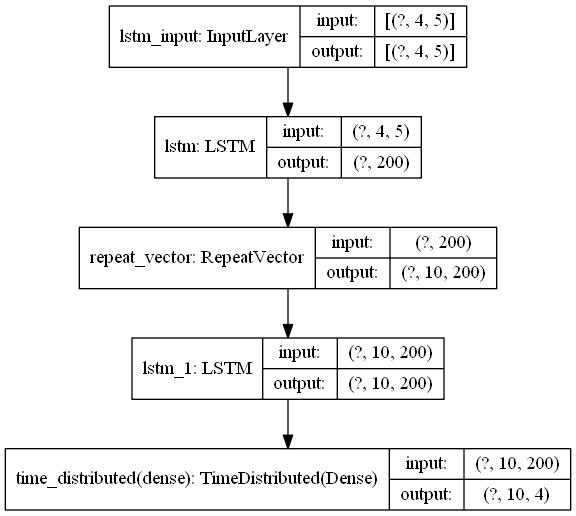

In [20]:
n_steps_in = num_input_ts
n_features_in = num_input_features
n_steps_out = num_pred_ts
n_features_out = num_pred_feat

model = keras.Sequential()
model.add(LSTM(200, activation='relu', input_shape=(n_steps_in, n_features_in)))
model.add(RepeatVector(n_steps_out))
model.add(LSTM(200, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(n_features_out)))
model.compile(optimizer='adam', loss='mae', metrics=['mae', 'accuracy'])
plot_model(model, to_file='model_plot1.png', show_shapes=True, show_layer_names=True)

In [21]:
# input_layer = Input(shape = (4,5))
# lstm1 = LSTM(50, activation='selu')(input_layer)
# rv = RepeatVector(10)(lstm1)
# #do1=Dropout(0.2)(lstm1)
# #rv = RepeatVector(21)(lstm1)
# #dense2 = Dense(100, activation='selu')(lstm1)
# lstm2 = LSTM(50, activation='selu', return_sequences=True)(rv)
# #do2=Dropout(0.2)(lstm2)
# #dense3 = Dense(100, activation='selu')(lstm2)
# lstm3 = LSTM(50, activation='selu', return_sequences=True)(lstm2)
# #dense4 = Dense(100, activation='selu')(lstm3)
# #do3 = Dropout(0.2)(lstm3)
# lstm4 = LSTM(50, activation='selu', return_sequences=True)(lstm3)
# #do4 = Dropout(0.2)(lstm4)
# #dense5 = Dense(100, activation='selu')(lstm4)
# lstm5 = LSTM(50, activation='selu', return_sequences=True)(lstm4)
# #do5 = Dropout(0.2)(lstm5)
# lstm6 = LSTM(50, activation='selu', return_sequences=True)(lstm5)
# #do6 = Dropout(0.2)(lstm6)
# lstm7 = LSTM(50, activation='selu', return_sequences=True)(lstm6)
# #do7 = Dropout(0.2)(lstm7)
# lstm8 = LSTM(50, activation='selu', return_sequences=True)(lstm7)
# #do8 = Dropout(0.2)(lstm8)
# lstm9 = LSTM(50, activation='selu', return_sequences=True)(lstm8)
# lstm10 = LSTM(50, activation='selu', return_sequences=True)(lstm9)
# lstm11 = LSTM(50, activation='selu', return_sequences=True)(lstm10)
# lstm12 = LSTM(50, activation='selu', return_sequences=True)(lstm11)
# lstm13 = LSTM(50, activation='selu', return_sequences=True)(lstm12)
# lstm14 = LSTM(50, activation='selu', return_sequences=True)(lstm13)
# lstm15 = LSTM(50, activation='selu', return_sequences=True)(lstm14)
# dense1 = Dense(10, activation='selu')(lstm15)
# output_layer = TimeDistributed(Dense(4))(lstm15)
# #output_layer = Dense(2)(lstm15)
# model = Model(input_layer, output_layer)

# optimizer=tf.optimizers.Nadam(lr=0.001, beta_1=0.9, beta_2=0.999)
# #optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.0, nesterov=True, name='SGD')
# #model.compile(optimizer='adam', loss='mae', metrics =['accuracy'])

# model.compile(optimizer, loss='mae', metrics =['mae'])
# plot_model(model, to_file='model_plot1.png', show_shapes=True, show_layer_names=True)

In [22]:
model_history = model.fit(X_train, y_train,
                          batch_size=128,
                          epochs = 100, 
                          validation_data=(X_valid, y_valid),
                          verbose = 1)

Train on 350000 samples, validate on 75000 samples
Epoch 1/100
350000/350000 [==============================] - 40s 114us/sample - loss: 3071488.5579 - mae: 3071483.7500 - accuracy: 0.8228 - val_loss: 967240.1952 - val_mae: 967240.1250 - val_accuracy: 0.8611
Epoch 2/100
350000/350000 [==============================] - 39s 110us/sample - loss: 824056.1437 - mae: 824056.1250 - accuracy: 0.9164 - val_loss: 440935.6122 - val_mae: 440935.3750 - val_accuracy: 0.9057
Epoch 3/100
350000/350000 [==============================] - 39s 110us/sample - loss: 347171.4560 - mae: 347171.5625 - accuracy: 0.9318 - val_loss: 269761.9410 - val_mae: 269761.9375 - val_accuracy: 0.9791
Epoch 4/100
350000/350000 [==============================] - 38s 109us/sample - loss: 287757.9706 - mae: 287758.0938 - accuracy: 0.9378 - val_loss: 184881.0112 - val_mae: 184881.0469 - val_accuracy: 0.9793
Epoch 5/100
350000/350000 [==============================] - 38s 107us/sample - loss: 474849.0501 - mae: 474848.6562 - accu

# Characterize, Test, and Evaluate the Model

In [23]:
# Convert training history to dataframe for analysis and plotting.
complete_history_data = pd.DataFrame(model_history.history)
complete_history_data.head(15)

,loss,mae,accuracy,val_loss,val_mae,val_accuracy
0,3.071489e+06,3.071484e+06,0.822842,967240.195167,967240.125000,0.861116
1,8.240561e+05,8.240561e+05,0.916434,440935.612247,440935.375000,0.905727
2,3.471715e+05,3.471716e+05,0.931766,269761.940993,269761.937500,0.979145
3,2.877580e+05,2.877581e+05,0.937834,184881.011220,184881.046875,0.979316
4,4.748491e+05,4.748487e+05,0.915349,284774.642050,284774.562500,0.942516
5,3.144270e+05,3.144274e+05,0.912085,262710.403453,262710.437500,0.974099
6,3.200713e+05,3.200712e+05,0.928402,207293.557263,207293.484375,0.885575
7,1.677583e+05,1.677585e+05,0.941078,90218.621947,90218.625000,0.946492
8,1.185505e+05,1.185506e+05,0.953085,69483.111636,69483.125000,0.879511
9,9.037270e+04,9.037255e+04,0.956077,78847.917247,78847.890625,0.887175


### Plot Learning Curves of Training

In [24]:
# Plotting Imports
import bokeh.io
bokeh.io.output_notebook()  # Set plot output to embed in notebook.
import bokeh.layouts
import bokeh.plotting
# Other imports for multi-plot figures.
from bokeh.io import output_file, show
from bokeh.layouts import column
from bokeh.plotting import figure

Loading BokehJS ...

In [25]:
def single_figure_twoline(y1, y2, plot_width, plot_height, title):
    """
    Function to plot learning curve of loss, error, or other metric vs
    the number of training epochs.

    Only one plot in the figure.
    """
    # Create X axis that iterates to the number of epochs in the 
    # training history.
    x = list(range(1,len(complete_history_data.index)))

    f = bokeh.plotting.figure(title=title,
                            plot_width=plot_width, 
                            plot_height=plot_height)
    f.multi_line(
      xs = [x, x],
      ys = [y1, y2],
      line_width=1,
      color=["firebrick", "navy"])

    return f

def single_testfigure_twoline(x, y1, y2, plot_width, plot_height, title):
    """
    Function to plot test data in comparison to predicted values.

    Only one plot in the figure.
    """

    f = bokeh.plotting.figure(title=title,
                            plot_width=plot_width, 
                            plot_height=plot_height)
    # Add a line for each of the 2 datasets.
    f.line(
        x,
        y1,
        line_width=1,
        color="navy",
        legend_label="y1"
    )
    f.line(
        x,
        y2,
        line_width=1,
        color="firebrick",
        legend_label="y2"
    )
    f.legend.location = 'top_left'
  
    return f

def plot_2D_body_time_series(pos_x_list, pos_y_list, plot_width, plot_height, title):
    """
    Accepts lists for x and y dimensions whose elements are time series data and whose
    index represents the number of the body in the simulation.
    
    returns Bokeh figure to plot.
    """
    # Create Bokeh figure to add plots to
    f = bokeh.plotting.figure(
        title = title,
        plot_width = plot_width,
        plot_height = plot_height
    )

    # Generate line for each body.
    # Randomly select color from palette using randint
    for i in range(0,len(pos_x_list)):
        f.line(
            pos_x_list[i],
            pos_y_list[i],
            line_width = 1,
            color = palette[randint(0,255)],
            legend_label = str(i)
        )
    f.legend.location = 'top_left'
    return f

In [26]:
# Assume y1 is the training loss and y2 is the validation loss.
# Extract loss tracking columns from dataframe.
fig = single_figure_twoline(
    y1 = complete_history_data[["loss"]].values, 
    y2 = complete_history_data[["val_loss"]].values, 
    plot_width=800, 
    plot_height=800,
    title = "AVG - Loss"
)

bokeh.plotting.show(fig)

### Evaluate the Model with Test Data

In [27]:
# Quick numerical evaluation on the test data.
model.evaluate([X_test],[y_test])

75000/75000 [==============================] - 10s 134us/sample - loss: 16485.3869 - mae: 16485.3906 - accuracy: 0.9933


[16485.386854270833, 16485.39, 0.99326265]

In [ ]:
# Grab predictions from model
y_pred = model.predict([X_test])

In [ ]:
# Select which of the target time steps to run comparison with.
# For example, if you enter 5, we will extract the displacements and velocities for 
# 5 time steps into the future.
future_time_step_to_evaluate = 5

In [ ]:
# Create Dateframe of predicted and actual values for plotting.
pred_model_comparison = pd.DataFrame(
    np.concatenate(
        (y_test[:, future_time_step_to_evaluate-1], y_pred[:, future_time_step_to_evaluate-1]), 
        axis=1
    )
)
# Create list of columns to assign to model comparison
cols = [
    'test_dis_x_' + str(future_time_step_to_evaluate),
    'test_dis_y_' + str(future_time_step_to_evaluate),
    'test_vel_x_' + str(future_time_step_to_evaluate),
    'test_vel_y_' + str(future_time_step_to_evaluate),
    'pred_dis_x_' + str(future_time_step_to_evaluate),
    'pred_dis_y_' + str(future_time_step_to_evaluate),
    'pred_vel_x_' + str(future_time_step_to_evaluate),
    'pred_vel_y_' + str(future_time_step_to_evaluate),
]
pred_model_comparison.columns = cols
# Rearrange columns in dataframe to put test and pred side-by-side.
cols = [
    'test_dis_x_' + str(future_time_step_to_evaluate),
    'pred_dis_x_' + str(future_time_step_to_evaluate),
    'test_dis_y_' + str(future_time_step_to_evaluate),
    'pred_dis_y_' + str(future_time_step_to_evaluate),
    'test_vel_x_' + str(future_time_step_to_evaluate),
    'pred_vel_x_' + str(future_time_step_to_evaluate),
    'test_vel_y_' + str(future_time_step_to_evaluate),
    'pred_vel_y_' + str(future_time_step_to_evaluate),
]
pred_model_comparison = pred_model_comparison[cols]

pred_model_comparison.head(15)

### Calculate Absolute Errors Between Test and Prediction

In [ ]:
# Calculate MAE for Displacement X
test_data_name = "test_dis_x_" + str(future_time_step_to_evaluate)
pred_data_name = "pred_dis_x_" + str(future_time_step_to_evaluate)

test_dis_x_mae = np.sum(
    np.absolute(
        pred_model_comparison[[test_data_name]].values - \
        pred_model_comparison[[pred_data_name]].values
    ),
    axis = 0
) / pred_model_comparison[[test_data_name]].values.shape[0]
test_dis_x_mean = np.mean(np.absolute(pred_model_comparison[[test_data_name]]))
# Calculate MAE for Displacement Y
test_data_name = "test_dis_y_" + str(future_time_step_to_evaluate)
pred_data_name = "pred_dis_y_" + str(future_time_step_to_evaluate)

test_dis_y_mae = np.sum(
    np.absolute(
        pred_model_comparison[[test_data_name]].values - \
        pred_model_comparison[[pred_data_name]].values
    ),
    axis = 0
) / pred_model_comparison[[test_data_name]].values.shape[0]
test_dis_y_mean = np.mean(np.absolute(pred_model_comparison[[test_data_name]]))
# Calculate MAE for Velocity X
test_data_name = "test_vel_x_" + str(future_time_step_to_evaluate)
pred_data_name = "pred_vel_x_" + str(future_time_step_to_evaluate)

test_vel_x_mae = np.sum(
    np.absolute(
        pred_model_comparison[[test_data_name]].values - \
        pred_model_comparison[[pred_data_name]].values
    ),
    axis = 0
) / pred_model_comparison[[test_data_name]].values.shape[0]
test_vel_x_mean = np.mean(np.absolute(pred_model_comparison[[test_data_name]]))
# Calculate MAE for Velocity Y
test_data_name = "test_vel_y_" + str(future_time_step_to_evaluate)
pred_data_name = "pred_vel_y_" + str(future_time_step_to_evaluate)

test_vel_y_mae = np.sum(
    np.absolute(
        pred_model_comparison[[test_data_name]].values - \
        pred_model_comparison[[pred_data_name]].values
    ),
    axis = 0
) / pred_model_comparison[[test_data_name]].values.shape[0]
test_vel_y_mean = np.mean(np.absolute(pred_model_comparison[[test_data_name]]))

print('Percent MAE of Average Test Value')
pd.DataFrame(
    np.array([
        (test_dis_x_mae[0] / test_dis_x_mean[0])*100,
        (test_dis_y_mae[0] / test_dis_y_mean[0])*100,
        (test_vel_x_mae[0] / test_vel_x_mean[0])*100,
        (test_vel_y_mae[0] / test_vel_y_mean[0])*100
    ]).reshape(-1,4),
    columns=[
        'dis_x_mae',
        'dis_y,mae',
        'vel_x_mae',
        'vel_y_mae'
    ]
)

### Plot Test and Predicted Values

In [ ]:
# Plot and compare the predicted test displacement x to predicted displacement x
fig = single_testfigure_twoline(
    x = list(range(0,len(pred_model_comparison.index))),
    y1 = pred_model_comparison[["test_dis_x_" + str(future_time_step_to_evaluate)]].values.reshape(-1,),
    y2 = pred_model_comparison[["pred_dis_x_" + str(future_time_step_to_evaluate)]].values.reshape(-1,),
    plot_width = 800,
    plot_height = 800,
    title = "Displacement_X - Predicted vs Actual"
)

bokeh.plotting.show(fig)

In [ ]:
# Plot and compare the predicted test displacement y to predicted displacement y
fig = single_testfigure_twoline(
    x = list(range(0,len(pred_model_comparison.index))),
    y1 = pred_model_comparison[["test_dis_y_" + str(future_time_step_to_evaluate)]].values.reshape(-1,),
    y2 = pred_model_comparison[["pred_dis_y_" + str(future_time_step_to_evaluate)]].values.reshape(-1,),
    plot_width = 800,
    plot_height = 800,
    title = "Displacement_y - Predicted vs Actual"
)

bokeh.plotting.show(fig)

In [ ]:
# Plot and compare the predicted test velocity x to predicted velocity x
fig = single_testfigure_twoline(
    x = list(range(0,len(pred_model_comparison.index))),
    y1 = pred_model_comparison[["test_vel_x_" + str(future_time_step_to_evaluate)]].values.reshape(-1,),
    y2 = pred_model_comparison[["pred_vel_x_" + str(future_time_step_to_evaluate)]].values.reshape(-1,),
    plot_width = 800,
    plot_height = 800,
    title = "Velocity X - Predicted vs Actual"
)

bokeh.plotting.show(fig)

In [ ]:
# Plot and compare the predicted test velocity y to predicted velocity y
fig = single_testfigure_twoline(
    x = list(range(0,len(pred_model_comparison.index))),
    y1 = pred_model_comparison[["test_vel_y_" + str(future_time_step_to_evaluate)]].values.reshape(-1,),
    y2 = pred_model_comparison[["pred_vel_y_" + str(future_time_step_to_evaluate)]].values.reshape(-1,),
    plot_width = 800,
    plot_height = 800,
    title = "Velocity y - Predicted vs Actual"
)

bokeh.plotting.show(fig)